<a href="https://colab.research.google.com/github/ErtKid/Machine_Learning_H3/blob/main/TP_ML_Fraude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP Fraude

In [29]:
!pip install h2o

In [30]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline

In [31]:
data = pd.read_csv('Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [32]:
address2country = pd.read_csv('IpAddress_to_Country.csv')
address2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [33]:
# Fonction pour obtenir le pays en fonction de l'adresse IP
def get_country(ip):
    try:
        return address2country[(address2country['lower_bound_ip_address'] <= ip) &
                               (address2country['upper_bound_ip_address'] >= ip)]['country'].iloc[0]
    except IndexError:
        return 'NA'

# Appliquer la fonction pour obtenir le pays et ajouter une nouvelle colonne 'country'
data['country'] = data['ip_address'].apply(get_country)


data.head()



,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [34]:
# Calculer la différence de temps entre 'purchase_time' et 'signup_time'
data['time_diff'] = (data['purchase_time'] - data['signup_time']).dt.total_seconds()


data.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0


In [35]:

device_counts = data.groupby('device_id').size().reset_index(name='device_num')


data = data.merge(device_counts, how='left', on='device_id')


data.head()




,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1


In [36]:

ip_counts = data.groupby('ip_address').size().reset_index(name='ip_num')


data = data.merge(ip_counts, how='left', on='ip_address')


data.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1,1


In [37]:
# Extraire le jour de la semaine et la semaine de l'année pour 'signup_time'
data['signup_day'] = data['signup_time'].dt.dayofweek  # 0: Lundi, 1: Mardi, etc.
data['signup_week'] = data['signup_time'].dt.week

# Extraire le jour de la semaine et la semaine de l'année pour 'purchase_time'
data['purchase_day'] = data['purchase_time'].dt.dayofweek  # 0: Lundi, 1: Mardi, etc.
data['purchase_week'] = data['purchase_time'].dt.week


data.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1,1,1,30,2,37


In [44]:
# Définir les caractéristiques (features)
features = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week',
            'purchase_value', 'source', 'browser', 'sex', 'age',
            'country', 'time_diff', 'device_num', 'ip_num']

# Définir la cible (target)
target = 'class'

data[[*features, target]].head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,4506682.0,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944.0,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1.0,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,492085.0,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,4361461.0,1,1,0


In [46]:
from sklearn.model_selection import train_test_split

# Définir les caractéristiques (features) et la cible (target)
features = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week',
            'purchase_value', 'source', 'browser', 'sex', 'age',
            'country', 'time_diff', 'device_num', 'ip_num']
target = 'class'

# Diviser les données en ensembles d'entraînement et de test
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)




In [50]:
from sklearn.ensemble import RandomForestClassifier

# Créer une instance du modèle
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement
rf_model.fit(X_train, y_train)


print("drf Model Build progress: |███████████████████████████████████████████████| 100%")



drf Model Build progress: |███████████████████████████████████████████████| 100%


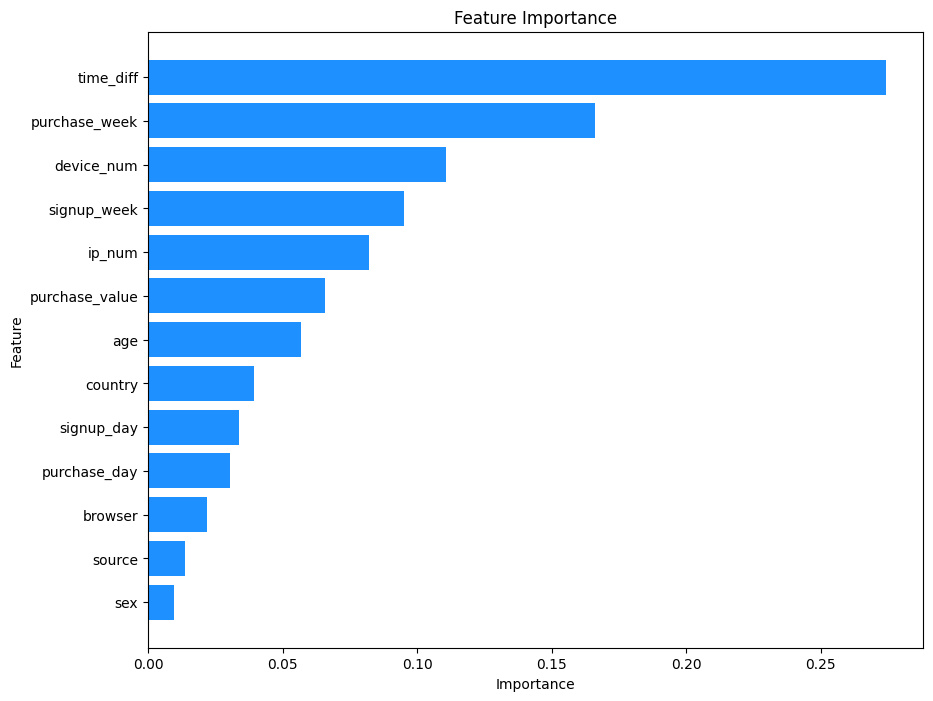

In [52]:
import matplotlib.pyplot as plt

# Trier le DataFrame en fonction de l'importance des caractéristiques
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=True)


plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='dodgerblue')


plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')


plt.show()



In [57]:
# Encodage à chaud des variables catégorielles
X = pd.get_dummies(data[features], drop_first=True)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement
rf_model.fit(X_train, y_train)

# Utiliser le modèle pour faire des prédictions sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Générer le rapport de classification
report = classification_report(y_test, y_pred, target_names=['0', '1'])


print("Classification Report:")
print(report)



Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41117
           1       1.00      0.54      0.70      4217

    accuracy                           0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



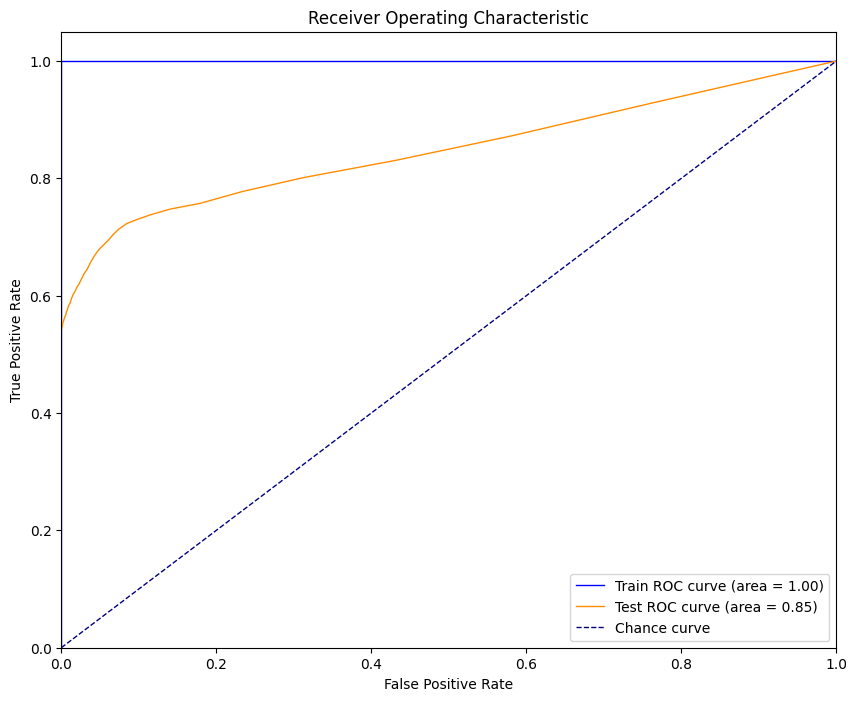

In [61]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtenir les probabilités de la classe positive pour l'ensemble d'entraînement
y_prob_train = rf_model.predict_proba(X_train)[:, 1]

# Calculer les taux de vrais positifs et de faux positifs pour l'ensemble d'entraînement
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)

# Calculer l'AUC pour l'ensemble d'entraînement
roc_auc_train = auc(fpr_train, tpr_train)

# Obtenir les probabilités de la classe positive pour l'ensemble de test
y_prob_test = rf_model.predict_proba(X_test)[:, 1]

# Calculer les taux de vrais positifs et de faux positifs pour l'ensemble de test
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

# Calculer l'AUC pour l'ensemble de test
roc_auc_test = auc(fpr_test, tpr_test)

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=1, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=1, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Chance curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
